# Fit an SVM using MACCS+FP fingerprints
This was the method that was described in the original [admetSAR](https://pubs.acs.org/doi/abs/10.1021/ci300367a) database

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from admet.features import SubstructureMatching
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC
from glob import glob
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import shutil
import os

## Load in the Datasets
Load all of them

In [2]:
csvs = glob(os.path.join('..', 'datasets', '*.csv'))
print(f'Found {len(csvs)} datasets')

Found 4 datasets


In [3]:
datasets = dict(
    (os.path.basename(f)[:-4], pd.read_csv(f)) for f in csvs
)

## Train an SVM
Estimate the performance of the models using 5-fold CV so we can compare to the paper.

In [4]:
model = Pipeline([
    ('featurize', SubstructureMatching()),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('svc', GridSearchCV(SVC(probability=True), cv=5, param_grid={
        'C': np.logspace(-4, 4, 10), 
    }))
])

In [5]:
test_name = 'T_Carc_I'
test_set = datasets[test_name]
print(f'Using {test_name} as a test case')

Using T_Carc_I as a test case


Run 5-fold cross-validation

In [6]:
k = StratifiedKFold(n_splits=5, shuffle=True)
score = cross_val_score(model, test_set['SMILES'], test_set['is_toxic'], cv=k,
                       scoring='accuracy')
print(f'Without modification: Accuracy = {score.mean() * 100: .2f}%')

Without modification: Accuracy =  87.37%


The admetSAR reports 88.4% for this dataset, so I think we're doing alright

In [7]:
baseline = test_set['is_toxic'].value_counts().max() / len(test_set)
print(f'Baseline accuracy: {baseline * 100: .2f}%')

Baseline accuracy:  78.16%


Evaluate change as we add more features

In [8]:
param_tuning = []
for nf in tqdm(np.logspace(1, np.log10(model[0].num_features), 8, dtype=np.int)):
    model[1].k = nf
    scores = [cross_val_score(model, test_set['SMILES'], test_set['is_toxic'], 
                              cv=k, scoring='accuracy', n_jobs=-1).mean() 
              for _ in range(8)]
    param_tuning.append({
        'k': nf,
        'scores': scores
    })

100%|██████████| 8/8 [09:26<00:00, 70.78s/it]


Compute some statistics

In [9]:
param_tuning = pd.DataFrame(param_tuning)
param_tuning['mean_score'] = param_tuning['scores'].apply(np.mean)
param_tuning['min_score'] = param_tuning['scores'].apply(min)
param_tuning['std_score'] = param_tuning['scores'].apply(np.std)

In [10]:
print(f'Best accuracy: {param_tuning["mean_score"].max()*100: .1f}%')

Best accuracy:  89.3%


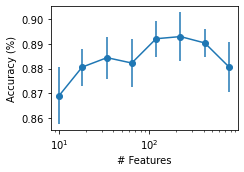

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.errorbar(param_tuning['k'], param_tuning['mean_score'], fmt='-o', yerr=param_tuning['std_score'])
ax.set_xscale('log')

ax.set_xlabel('# Features')
ax.set_ylabel('Accuracy (%)')
fig.tight_layout()

*Finding*: We are 200 features. There is not much variation once we get above 100.

## Perform 5-fold CV for All Models
Just to quickly assess the performance

In [12]:
model[1].k = 200

Train for all of the models. Run 5-fold cv for them to provide a summary

In [13]:
if os.path.isdir('models'):
    shutil.rmtree('models')
os.mkdir('models')

In [14]:
for name, dataset in tqdm(datasets.items()):
    # Fit the model
    model.fit(dataset['SMILES'], dataset['is_toxic'])
    
    # Save it to disk
    with open(os.path.join('models', f'{name}.pkl'), 'wb') as fp:
        pkl.dump(model, fp)
        
    # Run 5-fold cv
    cv_scores = cross_val_score(model, dataset['SMILES'], dataset['is_toxic'], 
                                cv=k, scoring='roc_auc', n_jobs=-1)
    print(f'{name} - 5-fold CV, Mean = {np.mean(cv_scores): .3f} All = {["%.3f"%x for x in cv_scores]}')

 25%|██▌       | 1/4 [00:13<00:39, 13.17s/it]

T_Carc_I - 5-fold CV, Mean =  0.886 All = ['0.873', '0.916', '0.906', '0.889', '0.844']


 50%|█████     | 2/4 [1:40:00<1:00:11, 1805.52s/it]

T_AMES_I - 5-fold CV, Mean =  0.890 All = ['0.879', '0.888', '0.892', '0.902', '0.887']


 75%|███████▌  | 3/4 [1:40:16<21:08, 1268.47s/it]  

T_hERG_I - 5-fold CV, Mean =  0.791 All = ['0.792', '0.830', '0.818', '0.822', '0.693']


100%|██████████| 4/4 [1:41:12<00:00, 1518.23s/it]

T_hERG_II - 5-fold CV, Mean =  0.845 All = ['0.875', '0.833', '0.826', '0.853', '0.837']
